In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score
from pandas import DataFrame
import seaborn as sns
import string

import nltk
from wordcloud import WordCloud, STOPWORDS
nltk.download('stopwords')
#nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Preprocessing Dataset

In [ ]:
clickbait = pd.read_csv("clickbait.csv")
notclickbait = pd.read_csv("notClickbait.csv")

clickbait_positive = [1 for i in range(clickbait.shape[0])]
clickbait_negative = [0 for i in range(notclickbait.shape[0])]

clickbait["isClickbait"] = clickbait_positive
notclickbait["isClickbait"] = clickbait_negative

dataset = pd.concat([clickbait, notclickbait])

dataset = dataset.drop(['ID', 'Favorites'], axis = 1)

In [ ]:
df = pd.read_csv('drive/MyDrive/clickbait_data.csv')

df.rename(columns = {'headline':'Video Title', 'clickbait':'isClickbait'}, inplace = True)
cols = [-1 for i in range(df.shape[0])]
df['Views'] = df['Likes'] = df['Dislikes'] = cols

merged_df = pd.concat([dataset, df])

In [ ]:
compression_opts = dict(method='zip', archive_name='clickbait_youtube_dataset.csv')
merged_df.to_csv('clickbait_youtube_dataset.zip', index=False, compression=compression_opts)

# Reading the data

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/clickbait_youtube_dataset.csv')

In [ ]:
data

,Video Title,Views,Likes,Dislikes,isClickbait
0,10 People You Don't Want To Mess With,484411,3881,191,1
1,I Got Hunted By The FBI,42724724,2005151,24646,1
2,10 Real Life Giants You Won't Believe Exist,3674544,12116,1570,1
3,10 Real Life Giants You Won't Believe Exist,6890718,15222,2858,1
4,10 Mythical CREATURES That Actually Existed,2089601,46750,1954,1
...,...,...,...,...,...
32196,"To Make Female Hearts Flutter in Iraq, Throw a...",-1,-1,-1,0
32197,"British Liberal Democrat Patsy Calton, 56, die...",-1,-1,-1,0
32198,Drone smartphone app to help heart attack vict...,-1,-1,-1,0
32199,"Netanyahu Urges Pope Benedict, in Israel, to D...",-1,-1,-1,0


In [ ]:
#for randomizing the dataframe (in case sorting by ID doesn't randomize properly)
data=data.sample(frac = 1)

# Exploratory Data Analysis

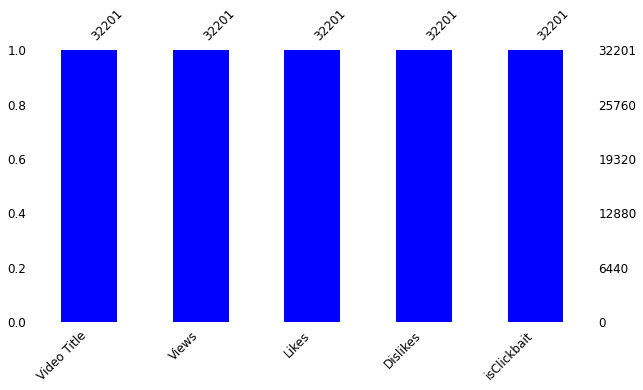

In [ ]:
msno.bar(data,color="blue", sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

In [ ]:
data.nunique()

Video Title    32196
Views            200
Likes            200
Dislikes         196
isClickbait        2
dtype: int64

# Lower Case Conversion, Tokenization, StopWord Removal and Lemmatization

In [ ]:
#lower casing
data["Video Title"] = data["Video Title"].str.lower()
print(data["Video Title"])

1416          do you belong with idris elba or john boyega
18074     anti-war protestors arrested outside white house
15557    your favorite '90s pop-punk anthem has been re...
7298     channing tatum to "lip sync battle" jenna dewa...
24676    roadside bomb kills 2 marines in southern afgh...
                               ...                        
22666    whoi sub nereus explores deepest area of pacif...
13941          17 bunnies for all the sad people out there
16863    deer and other animals found dead at ball stat...
11514    15 smart dollar store ideas to declutter your ...
12244    with a growing female audience, marvel hopes t...
Name: Video Title, Length: 32201, dtype: object


In [ ]:
#removing extra spaces
data["Video Title"] = data["Video Title"].apply(lambda x: x.strip())
print(data["Video Title"])

1416          do you belong with idris elba or john boyega
18074     anti-war protestors arrested outside white house
15557    your favorite '90s pop-punk anthem has been re...
7298     channing tatum to "lip sync battle" jenna dewa...
24676    roadside bomb kills 2 marines in southern afgh...
                               ...                        
22666    whoi sub nereus explores deepest area of pacif...
13941          17 bunnies for all the sad people out there
16863    deer and other animals found dead at ball stat...
11514    15 smart dollar store ideas to declutter your ...
12244    with a growing female audience, marvel hopes t...
Name: Video Title, Length: 32201, dtype: object


In [ ]:
#removing stopwords
stop = stopwords.words('english')
data["Video Title"] = data["Video Title"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
data["Video Title"] #after removing stopwords

1416                         belong idris elba john boyega
18074     anti-war protestors arrested outside white house
15557    favorite '90s pop-punk anthem recreated amazin...
7298     channing tatum "lip sync battle" jenna dewan t...
24676    roadside bomb kills 2 marines southern afghani...
                               ...                        
22666    whoi sub nereus explores deepest area pacific ...
13941                                17 bunnies sad people
16863        deer animals found dead ball state university
11514        15 smart dollar store ideas declutter kitchen
12244    growing female audience, marvel hopes invite e...
Name: Video Title, Length: 32201, dtype: object

In [ ]:
#removing punctuations
###DONT REMOVE PUNCTUATIONS
def remove_punctuation(text):
    punt = "".join([i for i in text if i not in string.punctuation])
    return punt
data["Video Title"] = data["Video Title"].apply(lambda x: remove_punctuation(x))
#test_text = test_text.apply(lambda x: remove_punctuation(x))

In [ ]:
#removing numbers
# Don't remove numbers
def remove_digits(text):
    digits = "".join([i for i in text if not i.isdigit()])
    return digits
data["Video Title"] = data["Video Title"].apply(lambda x: remove_digits(x))
#test_text = test_text.apply(lambda x: remove_digits(x))

In [ ]:
#lemmatization
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
#data["Video Title"] =  data["Video Title"].apply(lambda sentence: ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]))
#data["Video Title"] = data["Video Title"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
data["Video Title"] = data["Video Title"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
print(data["Video Title"])

14872               39 time `` 30 rock '' smartest show tv
19321              downing street welcome new resident cat
18763         another los angeles time promotion draw fire
19102    pizza 'lust ' campaign attracts numerous compl...
827                        10 awesome thing make duct tape
                               ...                        
25410                   conference final pit older younger
6697                17 drag queen transformation blow mind
2062                    15 super bowl snack worth feasting
15593                         corgicon san francisco great
26043    bad economy good time college basketball coach...
Name: Video Title, Length: 32201, dtype: object


In [ ]:
#creating seperate dataframes for each class
df_cb=data[data['isClickbait']==1]
df_noncb=data[data['isClickbait']==0]



#creating a list of unique words for each class
cb_list=list(df_cb['Video Title'])

total_vocab_cb = set()

for sent in cb_list:
    words=set([w for w in nltk.word_tokenize(sent)])
    total_vocab_cb.update(words)
len(total_vocab_cb)

#print(total_vocab_cb)

noncb_list=list(df_noncb['Video Title'])

total_vocab_noncb = set()
for sent in noncb_list:
    words=set([w for w in nltk.word_tokenize(sent)])
    total_vocab_noncb.update(words)
len(total_vocab_noncb)

flat_cb = [item for sublist in cb_list for item in nltk.word_tokenize(sublist)]
flat_noncb = [item for sublist in noncb_list for item in nltk.word_tokenize(sublist)]

print(flat_cb[0:100])
cb_freq = FreqDist(flat_cb)
noncb_freq = FreqDist(flat_noncb)

['39', 'time', '``', '30', 'rock', "''", 'smartest', 'show', 'tv', '10', 'awesome', 'thing', 'make', 'duct', 'tape', 'photo', 'make', '2016', 'baftas', 'look', 'like', 'golden', 'age', 'hollywood', 'secondary', '``', 'vampire', 'diary', "''", 'character', 'know', 'perfect', 'board', 'game', 'based', 'zodiac', 'sign', 'mother', "'s", 'eating', 'disorder', 'taught', '5', 'official', 'stage', 'canadian', 'accepting', 'winter', 'coming', 'sit', 'right', 'watch', 'rock', 'hit', 'quan', '17', 'confession', 'real', 'people', 'hate', 'partying', 'fill', 'blank', 'master', 'p', 'lyric', 'what', "'s", '2015', 'name', 'make', 'mini', 'nutella', 'pizza', 'young', 'trans', 'filmmaker', 'sundance', 'want', 'revolutionize', 'trans', 'storytelling', '27', 'breathtaking', 'alternative', 'traditional', 'wedding', 'bouquet', 'groom', 'fulfilled', 'childhood', 'dream', 'wedding', '``', 'back', 'future', "''", 'day', '22', 'picture']


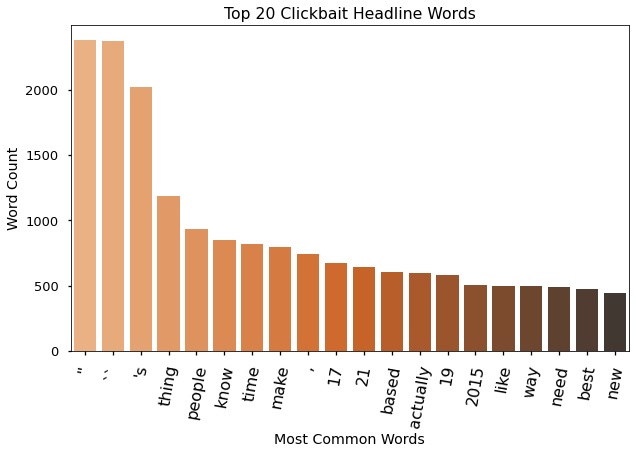

In [ ]:
# create counts of clickbait and non-clickbait words and values
cb_bar_counts = [x[1] for x in cb_freq.most_common(20)]
cb_bar_words = [x[0] for x in cb_freq.most_common(20)]

noncb_bar_counts = [x[1] for x in noncb_freq.most_common(20)]
noncb_bar_words = [x[0] for x in noncb_freq.most_common(20)]

plt.style.use('seaborn-talk')

#bar plot for top 15 most common clickbait words
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(x=cb_bar_words, y=cb_bar_counts,palette='Oranges_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style('white')
plt.savefig('clickbait_20_bar')
plt.show()

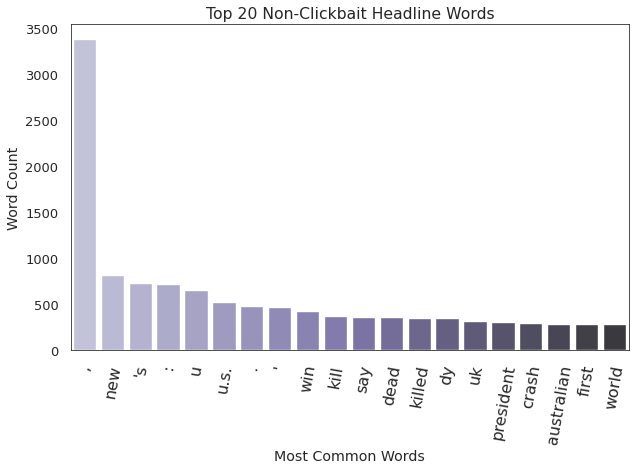

In [ ]:
#bar plot for top 15 most common non-clickbait words
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(x=noncb_bar_words, y=noncb_bar_counts,palette='Purples_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Non-Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style()
plt.show()

In [ ]:
data.head()

,Video Title,Views,Likes,Dislikes,isClickbait
14872,39 time `` 30 rock '' smartest show tv,-1,-1,-1,1
19321,downing street welcome new resident cat,-1,-1,-1,0
18763,another los angeles time promotion draw fire,-1,-1,-1,0
19102,pizza 'lust ' campaign attracts numerous compl...,-1,-1,-1,0
827,10 awesome thing make duct tape,-1,-1,-1,1


# Finding Unigram,Bigram and Trigram


In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CV().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_trigram(corpus, n=None):
    vec = CV(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
def plot_bt(x,w,p):
    common_words = x(data["Video Title"], 20)
    common_words_df = DataFrame (common_words,columns=['word','freq'])

    plt.figure(figsize=(16,8))
    sns.barplot(x='freq', y='word', data=common_words_df,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette(p,20))
    plt.title("Top 20 "+ w,)
    plt.xlabel("Frequency", fontsize=14)
    plt.yticks(fontsize=13)
    plt.xticks(rotation=45, fontsize=13)
    plt.ylabel("");
    return common_words_df

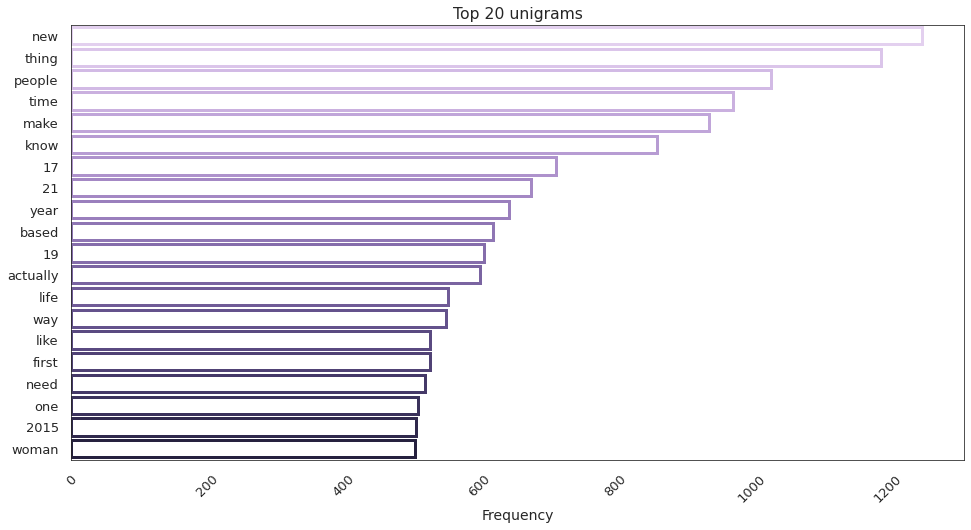

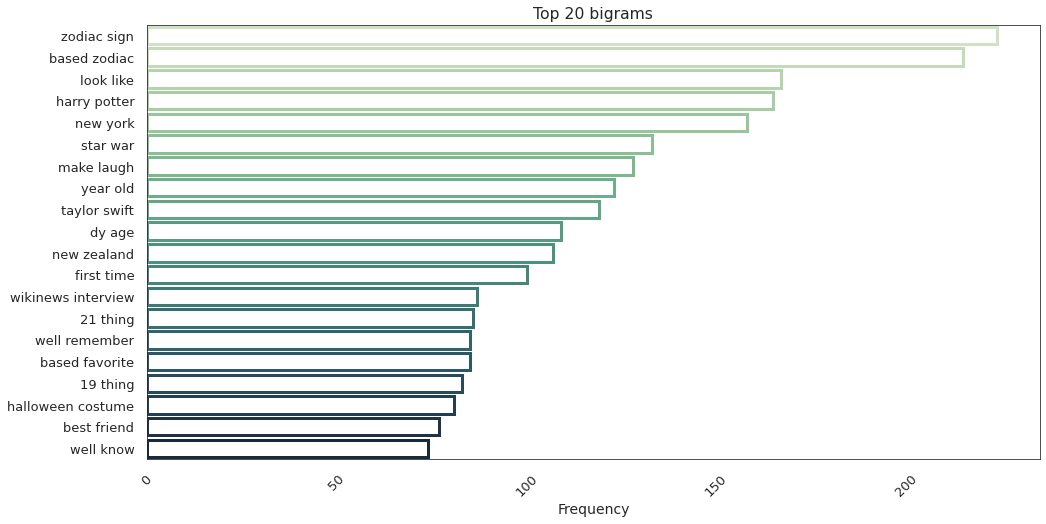

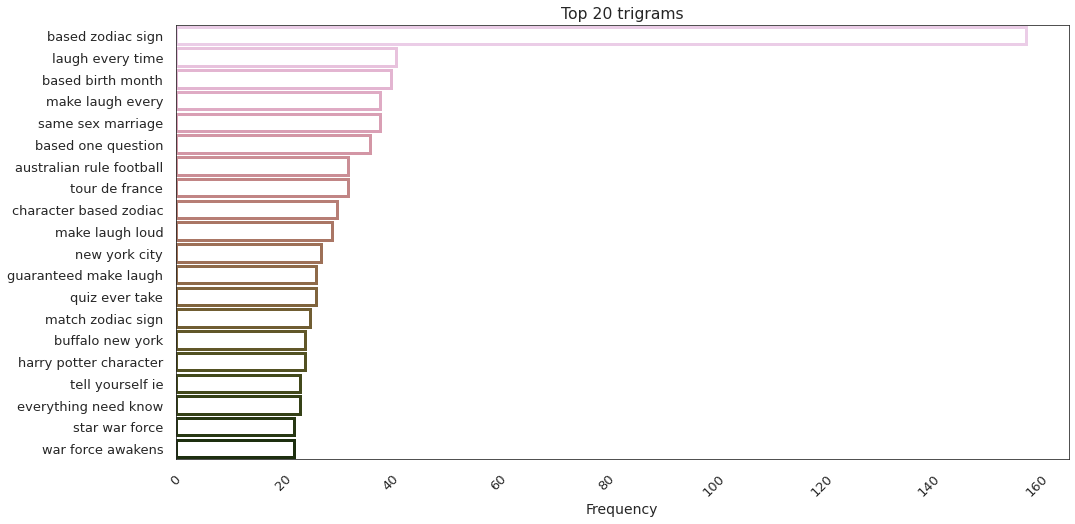

In [ ]:
common_words = get_top_n_words(data["Video Title"], 20)
common_words_df1 = DataFrame(common_words,columns=['word','freq'])
plt.figure(figsize=(16, 8))
ax = sns.barplot(x='freq', y='word', data=common_words_df1,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("ch:start=3, rot=.1",20))

plt.title("Top 20 unigrams")
plt.xlabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");

common_words_df2 = plot_bt(get_top_n_bigram,"bigrams","ch:rot=-.5")
common_words_df3 = plot_bt(get_top_n_trigram,"trigrams","ch:start=-1, rot=-.6")

# Word Cloud

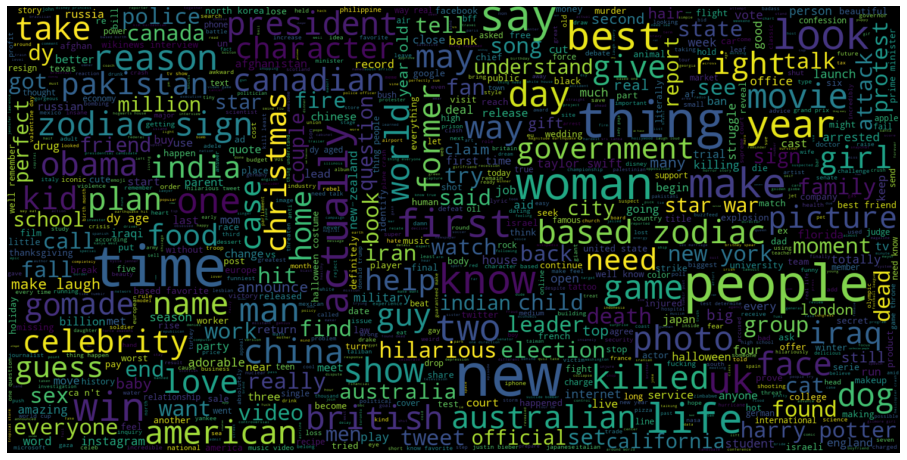

In [ ]:
# color function for the wordcloud
from wordcloud import WordCloud, STOPWORDS
plt.subplots(figsize=(16,16))
wc = WordCloud(stopwords=STOPWORDS,background_color="black",width=1500, height=750,max_words=1000, max_font_size=100)
wc.generate(' '.join(data["Video Title"]))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

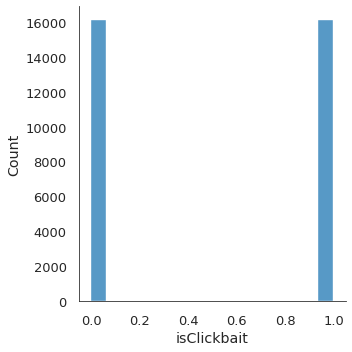

In [ ]:
sns.displot(data, x="isClickbait")

## Finding semantic and syntactic features

In [ ]:
print(data["Video Title"][24749])

28-day challenge get actually start working


In [ ]:
punclist=['!','#','?','.','$','@']
#No of punctuations
def count_punctuation(text):
    punt = "".join([i for i in text if i in punclist])
    return len(punt)
data["No_of_Punc"] = data["Video Title"].apply(lambda x: count_punctuation(x))

In [ ]:
#Mean length of title
def title_length(text):
  return len([x for x in text])
data["Title Length"]=data["Video Title"].apply(lambda x: title_length(x))

In [ ]:
#Views to likes ratio
data["Views to Likes"]=data["Views"]/data["Likes"]

In [ ]:
#views to dislikes
data["Views to Dislikes"]=data["Views"]/data["Dislikes"]
print(data.nunique(axis=0))

Video Title          32183
Views                  200
Likes                  200
Dislikes               196
isClickbait              2
No_of_Punc               9
Title Length           113
Views to Likes         200
Views to Dislikes      200
dtype: int64


In [ ]:
import torch
!pip install flair
import flair

     |████████████████████████████████| 322 kB 5.3 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 981 kB 30.7 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 788 kB 41.2 MB/s 
     |████████████████████████████████| 1.2 MB 37.1 MB/s 
     |████████████████████████████████| 19.7 MB 10.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 48 kB 5.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9692 sha256=9c2f665fc12ebe0e1e38d8b0354d580f330d14c4406a1c02016b029d695af7f9
  Stored in directory: /root/.cache/pip/wheels/ba/e0/7e/726e872a53f7358b4b96a9975b04e98113b005cd8609a63abc
  Created wheel for mpld3: filename=mpld3-0.3-py3-none-any.whl size=116702 sha256=0768b764c3a2c57c061d6b1

In [ ]:
#sentiment score
from flair.models import TextClassifier
from flair.data import Sentence
sia = TextClassifier.load('en-sentiment')
def flair_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        return 2
    elif "NEGATIVE" in str(score):
        return 0
    else:
        return 1
data["Sentiment score"] = data["Video Title"].apply(flair_prediction)

2022-04-06 07:18:19,018 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


In [ ]:
# for clickbait data
print(flair_prediction("I feel very down today! Help Me!!!"))

# for non clickbait data
print(flair_prediction("Morning News India"))

0
2


In [ ]:
data=data.drop(['Views', 'Likes', 'Dislikes'], axis=1)

In [ ]:
data

,Video Title,isClickbait,No_of_Punc,Title Length,Views to Likes,Views to Dislikes,Sentiment score
21191,"increase digital music sale slows , record lab...",0,0,72,1.0,1.0,0
14953,ryan reynolds surprise mega `` deadpool '' fan...,1,0,66,1.0,1.0,2
5509,21 thing actually win lottery,1,0,29,1.0,1.0,0
6582,13 eye-opening fact reveal india 's massive ob...,1,0,65,1.0,1.0,2
6990,7 easy thing improve life,1,0,25,1.0,1.0,2
...,...,...,...,...,...,...,...
7118,18 thing everyone date makeup addict know,1,0,41,1.0,1.0,2
3177,kind chip based zodiac sign,1,0,27,1.0,1.0,0
4078,peanut butter jelly bourbon exists gift u,1,0,41,1.0,1.0,2
10781,steak sandwich glorious terrifying,1,0,34,1.0,1.0,2


In [ ]:
print(data.nunique(axis=0))

Video Title          32183
isClickbait              2
No_of_Punc               9
Title Length           113
Views to Likes         200
Views to Dislikes      200
Sentiment score          2
dtype: int64


In [ ]:
data.to_csv("youtube_additional_features_1")

##Training Models

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/youtube_additional_features_1")

In [ ]:
#definining y and features
stopwords_list = stopwords.words('english')
features = data.drop(columns='isClickbait')
y = data['isClickbait']

X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=20)

tfidf = TfidfVectorizer(stop_words = stopwords_list,ngram_range = (1,2))
tfidf_text_train = tfidf.fit_transform(X_train['Video Title'])
tfidf_text_test = tfidf.transform(X_test['Video Title'])

X_train_ef = X_train.drop(columns='Video Title')
X_test_ef = X_test.drop(columns='Video Title')

In [ ]:
#combine tf-idf vectors with the engineered features and store as sparse arrays
from scipy import sparse

X_train = sparse.hstack([X_train_ef, tfidf_text_train]).tocsr()
X_test = sparse.hstack([X_test_ef, tfidf_text_test]).tocsr()

In [ ]:
print(X_train.shape)
print(X_test.shape)

(24150, 114823)
(8051, 114823)


In [ ]:
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_ML(title, views, likes, dislikes):
  title = title.lower()
  title = title.strip()
  title = " ".join([w for w in title.split() if w not in stop])
  title = " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(title)])
  no_of_punc = count_punctuation(title)
  title_len = title_length(title)
  views_to_like = views / likes
  views_to_dislike = views / dislikes
  sent_score = flair_prediction(title)

  info = [0, no_of_punc, title_len, views_to_like, views_to_dislike, sent_score]

  tfidf_title = tfidf.transform([title])

  final = sparse.hstack([info, tfidf_title]).tocsr()

  return final

##Naive Bayes

In [ ]:
nb_classifier = MultinomialNB(alpha = .05)

nb_classifier.fit(X_train, y_train)

nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

print(nb_test_preds, X_test[0])

score1 = metrics.accuracy_score(y_train, nb_train_preds)
print("Train accuracy:",score1)
score1 = metrics.accuracy_score(y_test, nb_test_preds)
print("Test accuracy:",score1)

print(metrics.classification_report(y_test, nb_test_preds))

print(metrics.confusion_matrix(y_test, nb_test_preds))

[0 0 1 ... 0 0 0]   (0, 0)	11893.0
  (0, 1)	1.0
  (0, 2)	38.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 868)	0.2950793548422508
  (0, 23134)	0.43683396217442283
  (0, 41628)	0.4343087835844125
  (0, 70262)	0.232012945182722
  (0, 88795)	0.3966836797191608
  (0, 88799)	0.4343087835844125
  (0, 105293)	0.3656064500960526
Train accuracy: 0.8971014492753623
Test accuracy: 0.8798906968078499
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3964
           1       0.97      0.79      0.87      4087

    accuracy                           0.88      8051
   macro avg       0.89      0.88      0.88      8051
weighted avg       0.90      0.88      0.88      8051

[[3874   90]
 [ 877 3210]]


In [ ]:
#clickbait
title = "5 minute hacks to get rich"
views = 5000
likes = 150
dislikes = 1000

#non-clickbait
titleN = "punkt"
viewsN = 41996418
likesN = 2900000
dislikesN = 1000

print(nb_classifier.predict(preprocess_ML(title, views, likes, dislikes)))
print(nb_classifier.predict(preprocess_ML(titleN, viewsN, likesN, dislikesN)))

[1]
[1]


##RandomForest

In [ ]:
rf_classifier = RandomForestClassifier(class_weight = 'balanced', n_estimators=100, )
rf_classifier.fit(X_train, y_train)

rf_test_preds = rf_classifier.predict(X_test)
rf_train_preds = rf_classifier.predict(X_train)

score1 = metrics.accuracy_score(y_train, rf_train_preds)
print("Train accuracy:",score1)
score1 = metrics.accuracy_score(y_test, rf_test_preds)
print("Test accuracy:",score1)

print(metrics.classification_report(y_test, rf_test_preds))


print(metrics.confusion_matrix(y_test, rf_test_preds))

Train accuracy: 1.0
Test accuracy: 0.9959011302943733
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3964
           1       0.99      1.00      1.00      4087

    accuracy                           1.00      8051
   macro avg       1.00      1.00      1.00      8051
weighted avg       1.00      1.00      1.00      8051

[[3935   29]
 [   4 4083]]


In [ ]:
#clickbait
title = "5 minute hacks to get rich"
views = 5000
likes = 150
dislikes = 1000

#non-clickbait
titleN = "punkt"
viewsN = 41996418
likesN = 2900000
dislikesN = 1000

print(nb_classifier.predict(preprocess_ML(title, views, likes, dislikes)))
print(nb_classifier.predict(preprocess_ML(titleN, viewsN, likesN, dislikesN)))

[1]
[1]


##SVM

In [ ]:
from sklearn.svm import LinearSVC

svm_classifier = LinearSVC(class_weight='balanced', C=10, max_iter = 1500 )

#training
svm_classifier.fit(X_train, y_train)

svm_test_preds = svm_classifier.predict(X_test)
svm_train_preds = svm_classifier.predict(X_train)

score1 = metrics.accuracy_score(y_train, svm_train_preds)
print("Train accuracy:",score1)
score1 = metrics.accuracy_score(y_test, svm_test_preds)
print("Test accuracy:",score1)

print(metrics.classification_report(y_test, svm_test_preds))

print(metrics.confusion_matrix(y_test, svm_test_preds))

Train accuracy: 0.9944099378881988
Test accuracy: 0.9626133399577692
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3999
           1       0.97      0.96      0.96      4052

    accuracy                           0.96      8051
   macro avg       0.96      0.96      0.96      8051
weighted avg       0.96      0.96      0.96      8051

[[3861  138]
 [ 163 3889]]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


##XGBoost

In [ ]:
# Cast the numerical features to floats.
data["No_of_Punc"] = data["No_of_Punc"].astype('float')
data["Views to Likes"] = data["Views to Likes"].astype('float')
data["Views to Dislikes"] = data["Views to Dislikes"].astype('float')
data["Title Length"] =data["Title Length"].astype('float')

In [ ]:
features = data.drop(['isClickbait','Video Title'],axis=1)
y = data['isClickbait']
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=20)

In [ ]:
from xgboost import XGBClassifier

# Create an instance of the classifier
model = XGBClassifier()

# Train it on the training set.
model.fit(X_train, y_train)

# Use the trained model to predict the labels for the test set.
predictions = model.predict(X_test)

# Calculate the F1 score.
f1 = f1_score(y_true = y_test,y_pred = predictions)

print('Using XGBoost on non-text features')
print('\nF1: %.3f' % f1)

Using XGBoost on non-text features...

F1: 0.648


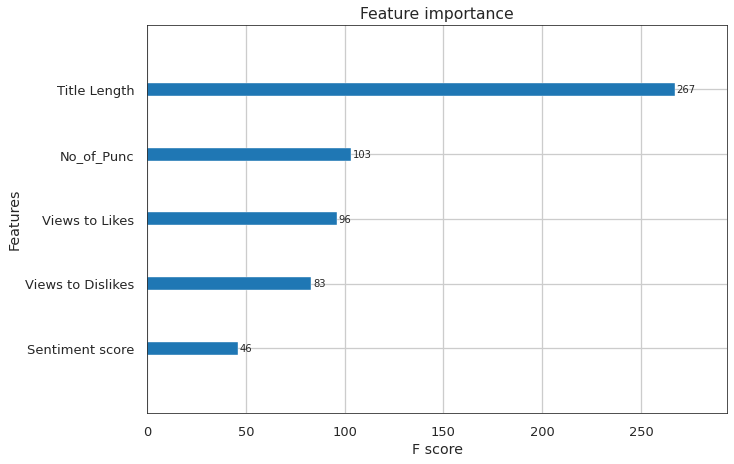

In [ ]:
#most imp among numerical features
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(model)

pyplot.show()

##BERT 

In [ ]:
data

,Unnamed: 0,Video Title,isClickbait,No_of_Punc,Title Length,Views to Likes,Views to Dislikes,Sentiment score
0,1416,belong idris elba john boyega,1,0,29,1.0,1.0,2
1,18074,anti-war protestors arrested outside white house,0,0,48,1.0,1.0,0
2,15557,favorite '90s pop-punk anthem recreated amazin...,1,0,53,1.0,1.0,2
3,7298,channing tatum `` lip sync battle '' jenna dew...,1,0,54,1.0,1.0,2
4,24676,roadside bomb kill 2 marine southern afghanistan,0,0,48,1.0,1.0,0
...,...,...,...,...,...,...,...,...
32196,22666,whoi sub nereus explores deepest area pacific ...,0,0,51,1.0,1.0,2
32197,13941,17 bunny sad people,1,0,19,1.0,1.0,0
32198,16863,deer animal found dead ball state university,0,0,44,1.0,1.0,0
32199,11514,15 smart dollar store idea declutter kitchen,1,0,44,1.0,1.0,2


In [ ]:
sen_w_feats = []
labels = []
 
# replacing the NaN values with empty string.
data = data.fillna("")


print('Combining features into strings')

for index, row in data.iterrows():

    # Piece it together...    
    combined = ""
    
   
    combined += "{:} {:} {:} {:} {:} {:} ".format(row["Video Title"], 
                                                       row["Title Length"],
                                                       row["No_of_Punc"], 
                                                       row["Views to Likes"], 
                                                       row["Views to Dislikes"], 
                                                       row["Sentiment score"])
    
    #Adding the combined text to the list.
    sen_w_feats.append(combined)

    #Adding the label to labels list
    labels.append(row["isClickbait"])

print('Dataset contains {:,} samples.'.format(len(sen_w_feats)))

Combining features into strings
Dataset contains 32,201 samples.


In [ ]:
#viz result
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

print(wrapper.fill(sen_w_feats[100]))

word association test determine personality 43 0 1.0 1.0 2


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 43.2 MB/s 
     |████████████████████████████████| 6.5 MB 33.7 MB/s 
     |████████████████████████████████| 596 kB 45.0 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 32

learning_rate = 1e-5

# Number of training epochs. 
epochs = 2

In [ ]:
max_len = 0

# For every sentence...
for sent in sen_w_feats:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  58


In [ ]:
max_len = 70

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Encoding all reviews in the dataset...')

# For every sentence...
for sent in sen_w_feats:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('DONE.')
print(tokenizer.convert_ids_to_tokens(encoded_dict['input_ids'][0]))

Encoding all reviews in the dataset...
DONE.
['[CLS]', 'growing', 'female', 'audience', ',', 'marvel', 'hope', 'invite', 'everyone', '53', '0', '1', '.', '0', '1', '.', '0', '2', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
import random
import numpy as np

# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - (train_size + val_size)

# Sanity check the sizes.
assert((train_size + val_size + test_size) == len(data))

# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(data))

# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 25,760
Validation size: 3,220
      Test size: 3,221


In [ ]:
from torch.utils.data import TensorDataset

# Split the samples, and create TensorDatasets for each split. 
train_dataset = TensorDataset(input_ids[train_idx], attention_masks[train_idx], labels[train_idx])
val_dataset = TensorDataset(input_ids[val_idx], attention_masks[val_idx], labels[val_idx])
test_dataset = TensorDataset(input_ids[test_idx], attention_masks[test_idx], labels[test_idx])

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
   
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

      
        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

     
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
  
    # Validation
   
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
     
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        
        with torch.no_grad():        

        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

       
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    805.    Elapsed: 0:00:29.
  Batch    80  of    805.    Elapsed: 0:00:57.
  Batch   120  of    805.    Elapsed: 0:01:26.
  Batch   160  of    805.    Elapsed: 0:01:55.
  Batch   200  of    805.    Elapsed: 0:02:24.
  Batch   240  of    805.    Elapsed: 0:02:53.
  Batch   280  of    805.    Elapsed: 0:03:22.
  Batch   320  of    805.    Elapsed: 0:03:51.
  Batch   360  of    805.    Elapsed: 0:04:20.
  Batch   400  of    805.    Elapsed: 0:04:49.
  Batch   440  of    805.    Elapsed: 0:05:17.
  Batch   480  of    805.    Elapsed: 0:05:46.
  Batch   520  of    805.    Elapsed: 0:06:15.
  Batch   560  of    805.    Elapsed: 0:06:44.
  Batch   600  of    805.    Elapsed: 0:07:13.
  Batch   640  of    805.    Elapsed: 0:07:42.
  Batch   680  of    805.    Elapsed: 0:08:11.
  Batch   720  of    805.    Elapsed: 0:08:40.
  Batch   760  of    805.    Elapsed: 0:09:09.
  Batch   800  of    805.    Elapsed: 0:09:38.

  Average traini

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')


df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.15,0.11,0.96,0:09:41,0:00:26
2,0.07,0.09,0.97,0:09:42,0:00:26


In [ ]:
# Create a DataLoader to batch our test samples
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,221 test sentences...
    DONE.


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:

score1 = metrics.accuracy_score(flat_true_labels, flat_predictions)
print("Test accuracy:",score1)

print(metrics.classification_report(flat_true_labels, flat_predictions))
print(metrics.confusion_matrix(flat_true_labels, flat_predictions))

#print('F1 Score: %.3f' % f1)

Test accuracy: 0.9754734554486184
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1635
           1       0.97      0.98      0.98      1586

    accuracy                           0.98      3221
   macro avg       0.98      0.98      0.98      3221
weighted avg       0.98      0.98      0.98      3221

[[1592   43]
 [  36 1550]]


In [ ]:
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_test(title, views, likes, dislikes):
  title = title.lower()
  title = title.strip()
  title = " ".join([w for w in title.split() if w not in stop])
  title = " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(title)])
  no_of_punc = count_punctuation(title)
  title_len = title_length(title)
  views_to_like = views / likes
  views_to_dislike = views / dislikes
  sent_score = flair_prediction(title)

  merged_data = ""
  merged_data += "{:} {:} {:} {:} {:} {:} ".format(title, 
                                                       title_len,
                                                       no_of_punc, 
                                                       views_to_like, 
                                                       views_to_dislike, 
                                                       sent_score)
  return merged_data

In [ ]:
title = "5 minute hacks to get rich"
views = 5000
likes = 150
dislikes = 1000

In [ ]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
merged = preprocess_test(title, views, likes, dislikes)

In [ ]:
#inputs = tokenizer(merged, return_tensors="pt")
#outputs = model(**inputs)

#y_pred = model.predict(merged)

import tensorflow as tf


test_eg = [merged]
test_data = tf.data.Dataset.from_tensor_slices((test_eg, [0] * len(test_eg)))
# wrap test data into BERT format
test_data = (test_data.map(to_feature_map_bert).batch(1))
preds = model.predict(test_data)
print(preds)
#['Insincere' if pred >=0.5 else 'Sincere' for pred in preds]